<a href="https://colab.research.google.com/github/nobu-n2002/PixelFlow/blob/main/PixelNote_FY2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Preprocessing for Immersed Boundary Navier-Stokes equation

In this notebook, general image processing techniques are employed on 2D images and subsequently applied to a numerical simulation program using the immersed boundary Navier-Stokes equation.

# 1. Preparation before execution

## 1-1. Connect to Google Drive

In [1]:
# @title Connect to Google Drive

from google.colab import drive

# Mount Google Drive if selected
drive.mount('/content/drive')
print('Google Drive connected!')

Mounted at /content/drive
Google Drive connected!


## 1-2. Importing non-standard modules
Install non-standard modules on Google Colab. This won't affect your local environment.

In [2]:
#@title Importing non-standard modules into Colabo

%%capture

# update apt-get and upgrade pip (for installing modules)
!apt-get update
!apt-get upgrade pip

# pyheif : use to convert heic files to png
%pip install pyheif
%pip install ffmpeg

## 1-3. Making Directory

This code is a simple script for creating folders on Google Colab. Each folder serves a different purpose.

- **bin:** Stores executable files or programs.

- **data:** Used for datasets and project data.

- **logs:** Reserved for execution logs and important events.

- **src:** For storing source code and scripts.

- **config:** Holds configuration files.

- **tmp:** Temporary files and working data.

- **output:** Saves project outputs and results.

- **fig:** Saves output figures.

In [3]:
#@title Making Directory

%mkdir -p bin data logs src config tmp output fig

# 2. Image processing

The image file is converted to grayscale, and a blur is applied as a variant distance function to generate a porosity distribution.


## 2-1. File Input

Enable `use_upload: [check]` to choose a local file. Alternatively, manually input the file path into `file_path:`.

arrow successfully read
Original resolution: (756, 756)
Save the figure in ./tmp/original.png


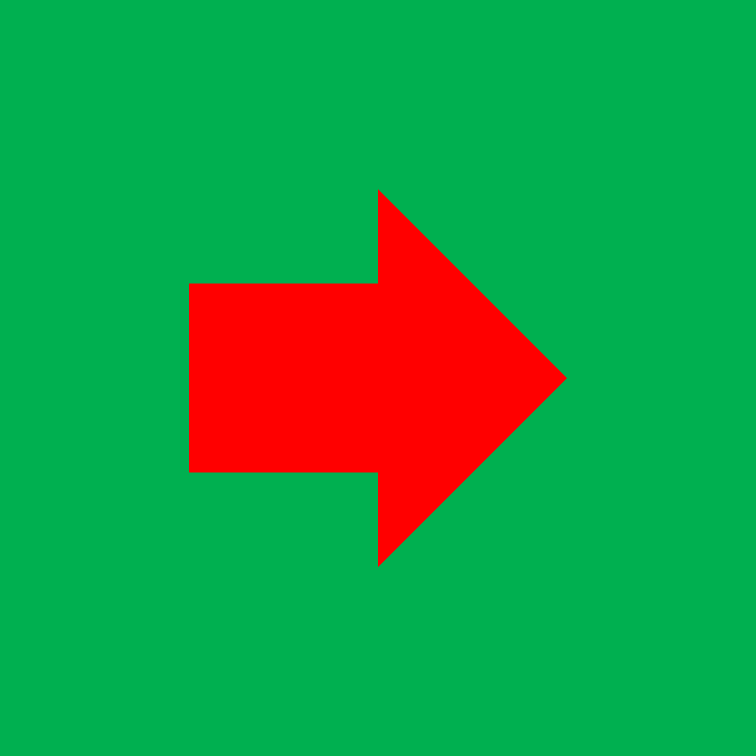

In [4]:
# @title File Input { vertical-output: true, display-mode: "form" }

import os
import sys
from IPython.display import display, Image
from PIL import Image as PILImage
import cv2
import numpy as np
import pyheif
from google.colab import files
import matplotlib.pyplot as plt

# Function to convert HEIC to PNG
def heif_to_image(path):
    heif_file = pyheif.read(path)
    img = PILImage.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride,
    )
    print('HEIC successfully converted into PNG')
    return img

# Function to handle transparency (fill transparent parts with white)
def fill_transparency_with_white(image):
    if image.shape[-1] == 4:  # Check if the image has an alpha channel
        # Split into color and alpha channels
        b, g, r, a = cv2.split(image)

        # Normalize alpha channel to range [0, 1] for blending
        alpha = a / 255.0

        # Create a white background image
        white_background = np.ones_like(b, dtype=np.uint8) * 255

        # Blend each channel with the white background
        b = (b * alpha + white_background * (1 - alpha)).astype(np.uint8)
        g = (g * alpha + white_background * (1 - alpha)).astype(np.uint8)
        r = (r * alpha + white_background * (1 - alpha)).astype(np.uint8)

        # Merge the channels back into a BGR image (no alpha)
        return cv2.merge((b, g, r))

    # If no alpha channel, return the original image
    return image

# Parameters
use_upload = False  # @param {type:"boolean"}
file_path = "/content/drive/MyDrive/Informatics-FY2024/input/arrow.jpg"  # @param {type:"string"}
upload_button = None

# Upload files if selected
if use_upload:
    upload_button = files.upload()

# Get the file path
if use_upload and len(upload_button) > 0:
    file_path_input = list(upload_button.keys())[0]
    file_path = file_path_input
else:
    file_path_input = file_path

# Check if the file exists
if os.path.exists(file_path_input):
    file_name, file_extension = os.path.splitext(os.path.basename(file_path_input))

    # Check if the file is in HEIC format and convert to PNG if needed
    if file_extension.lower() == '.heic' or file_extension.lower() == '.HEIC':
        img = heif_to_image(file_path_input)
        img.save(f"./tmp/{file_name}.png", "PNG")
        file_path = f"./tmp/{file_name}.png"

    print(f'{file_name} successfully read')
    # Read the image with alpha channel if present
    original_image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

    # Handle transparency
    original_image = fill_transparency_with_white(original_image)

    # Save the processed image
    height, width = original_image.shape[0:2]
    file_path_original = f"./tmp/original.png"
    cv2.imwrite(file_path_original, original_image)

    print('Original resolution:', original_image.shape[0:2])
    print('\033[32m' + f'Save the figure in {file_path_original}' + '\033[0m')
    display(Image(file_path_original, width=300))
else:
    sys.exit('No file input')


## 2-2. Cropping and Adding Margins

Add padding to the loaded file. The original resolution of the file can be found in the code block above [File Input] with `Original resolution: (WIDTH, HEIGHT)`, allowing you to verify it. Add a margin of `MARGIN` pixels to match that resolution. Choose `surroundings` for padding around the image.


Original resolution: (756, 756)
Processed resolution: (1360, 2570)
Save the figure in /content/tmp/cropped.png


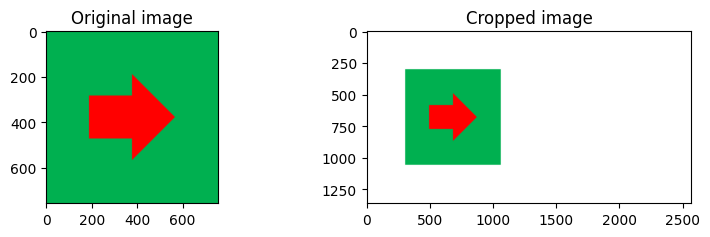

In [5]:
# @title Cropping and Adding Margins { run: "auto", vertical-output: true, display-mode: "form" }
# Import modules
import os
import cv2
import numpy as np
from IPython.display import display, Image
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Current working directory
CWD = os.getcwd()

file_path_original = f"./tmp/original.png"

# Read an image with alpha channel (if present)
src = cv2.imread(file_path_original, cv2.IMREAD_UNCHANGED)
h_ori, w_ori = src.shape[:2]
print('Original resolution:', src.shape[:2])

# Handle alpha channel (if present)
if src.shape[-1] == 4:  # Check if image has alpha channel
    # Split channels
    b, g, r, a = cv2.split(src)

    # Create a white background
    white_background = 255 * np.ones((h_ori, w_ori), dtype=np.uint8)

    # Replace transparent parts with white
    b = cv2.bitwise_or(b, white_background, mask=a)
    g = cv2.bitwise_or(g, white_background, mask=a)
    r = cv2.bitwise_or(r, white_background, mask=a)

    # Merge the channels back without alpha
    src = cv2.merge((b, g, r))

# Set margin parameters
square = True
x, y = 0, 0
margin_factor_x, margin_factor_y = 0, 0

# Calculate margin for square
if square:
    tmp = h_ori - w_ori
    if tmp <= 0:
        x = int(abs(tmp) / 2)
    else:
        y = int(abs(tmp) / 2)

# Set margin factors based on type
top = 0.4 # @param {type:"slider", min:0, max:5, step:0.1}
left = 0.4 # @param {type:"slider", min:0, max:5, step:0.1}
bottom = 0.4 # @param {type:"slider", min:0, max:5, step:0.1}
right = 2 # @param {type:"slider", min:0, max:5, step:0.1}

# Add margin to the image
img = cv2.copyMakeBorder(src, int(h_ori * top + x), int(h_ori * bottom + x),
                         int(w_ori * left + y), int(w_ori * right + y),
                         cv2.BORDER_CONSTANT, value=[255, 255, 255])

# Save the processed image
file_path_cropped = f"{CWD}/tmp/cropped.png"
cv2.imwrite(file_path_cropped, img)

# Display the processed image
print('Processed resolution:', img.shape[:2])
print('\033[32m' + f'Save the figure in {file_path_cropped}' + '\033[0m')

# Plot results for visualization
fig = plt.figure(figsize=(10, 6))  # 全体のサイズ
gs = GridSpec(1, 2, width_ratios=[1, (right+left+1)], wspace=0.05)  # 比率を調整して余白を小さく

# Display the original image
axs0 = fig.add_subplot(gs[0])
axs0.imshow(cv2.cvtColor(cv2.imread(file_path_original, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB))
axs0.set_title('Original image')
axs0.axis('on')

# Display the cropped image
axs1 = fig.add_subplot(gs[1])
axs1.imshow(cv2.cvtColor(cv2.imread(file_path_cropped), cv2.COLOR_BGR2RGB))
axs1.set_title('Cropped image')
axs1.axis('on')

bbox0 = axs0.get_position()
bbox1 = axs1.get_position()
axs1.set_position([bbox1.x0, bbox0.y0, bbox1.width, bbox0.height])

plt.show()

##2-3. Grayscale

Grayscaling can be easily achieved by loading the previously resized image using OpenCV's `IMREAD_GRAYSCALE` function. Here, we explain the process that takes place within the image during the grayscaling process.

Each pixel in the image has a specific RGB (Red, Green, Blue) value, where each color has 256 steps ranging from 0 to 255 ($2^8$). By performing the following operations on these RGB values, a grayscale image can be generated. This method follows the "Luminosity Method (ITU-R BT.601)."

$$ \rm{Gray} = Red \times 0.229 + Green \times 0.587 + Blue \times 0.114 $$

The following code block (the greyscale tester) conducts a test to convert an original BGR color (specified by user input) to grayscale by applying custom weights to each channel (B, G, R). Users can set these custom weights through sliders. The resulting grayscale intensity is calculated based on the specified weights, and the original and grayscale images are displayed side by side for visual comparison.

###2-3-1. Grayscale and Threshold

When generating a grayscale image, set all values greater than the threshold to 255 (white). Adjust the grayscale weighting and threshold value to effectively lighten the background by enhancing its white tones.

$$ \rm{Gray} = Red \times w_1/w + Green \times w_2/w + Blue \times w_3/w$$
$$ \rm{w=w_1+w_2+w_3}$$

Custom weights: [0.0, 1.0, 0.0]


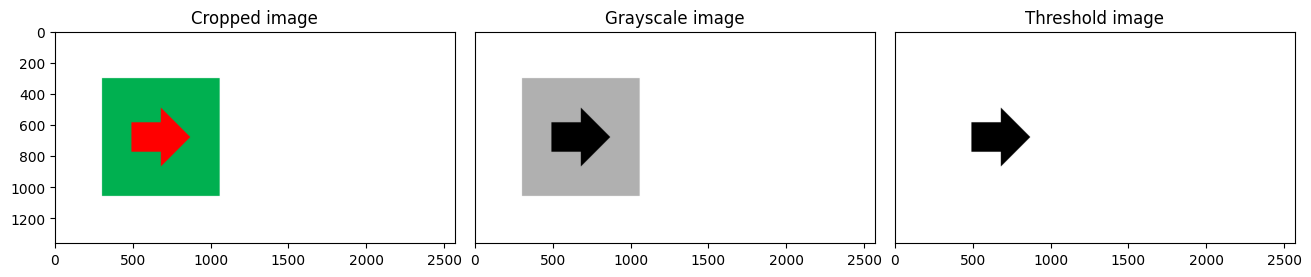

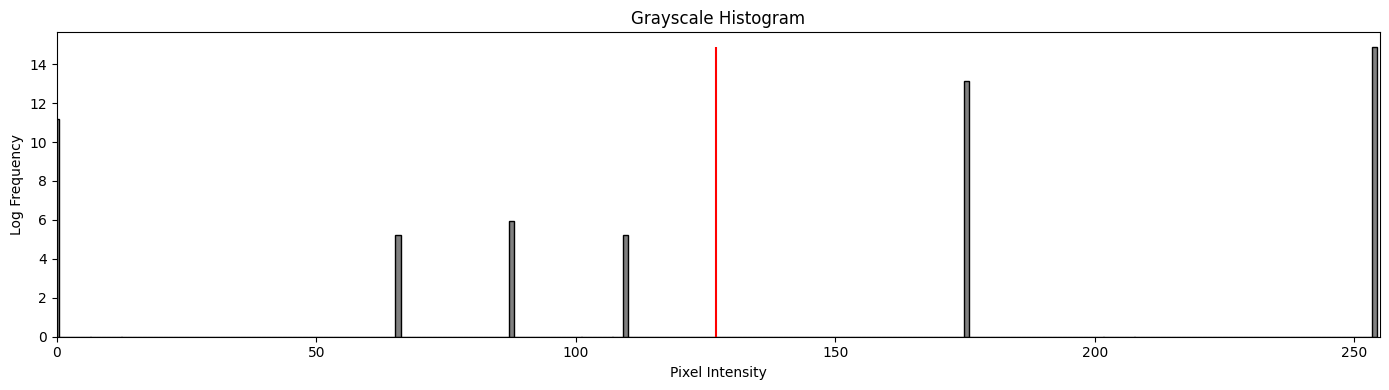

In [24]:
# @title Grayscale and Threshold with Histogram {vertical-output: true }

from IPython.display import Image
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from matplotlib.gridspec import GridSpec

# Define custom weights for RGB to grayscale conversion
def custom_rgb_to_grayscale(image, weights=[0.229, 0.587, 0.114]):
    """
    Convert a 3-channel RGB image to grayscale using custom weights.

    Parameters:
    - image (numpy.ndarray): Input RGB image.
    - weights (list): Custom weights for each RGB channel. Default is [0.229, 0.587, 0.114].

    Returns:
    - numpy.ndarray: Grayscale image.
    """
    if len(image.shape) == 3 and image.shape[2] == 3:  # Ensure input is RGB
        gray_image = np.dot(image[..., :3], weights)
    else:
        raise ValueError("Input image must be a 3-channel RGB image.")
    return gray_image

# Custom weights for RGB to grayscale conversion
w1 = 0  # @param {type:"slider", min:0, max:1, step:0.01}
w2 = 1  # @param {type:"slider", min:0, max:1, step:0.01}
w3 = 0  # @param {type:"slider", min:0, max:1, step:0.01}
w = w1 + w2 + w3
custom_weights = [w3 / w, w2 / w, w1 / w]

print('Custom weights:', custom_weights)

# File paths
CWD = os.getcwd()
file_path_cropped = f"{CWD}/tmp/cropped.png"
file_path_gray = f"{CWD}/tmp/gray.png"
file_path_threshold = f"{CWD}/tmp/threshold.png"
file_path_hist = f"{CWD}/tmp/histgram.png"

# Remove existing images if they exist
for file_path in [file_path_gray, file_path_threshold, file_path_hist]:
    if os.path.exists(file_path):
        os.remove(file_path)

# Read the input image
IMG = cv2.imread(file_path_cropped, cv2.IMREAD_UNCHANGED)

# Threshold parameters
threshold = 127  # @param {type:"slider", min:0, max:255, step:1}
inverse = False  # @param {type:"boolean"}

# Convert image to grayscale using custom weights
IMG_GRAY = custom_rgb_to_grayscale(IMG, custom_weights)

# Save grayscale image
cv2.imwrite(file_path_gray, IMG_GRAY)

# Apply thresholding to grayscale image
IMG_THRESHOLDED = IMG_GRAY.copy()
IMG_THRESHOLDED[IMG_THRESHOLDED > threshold] = 255.0

# Invert grayscale image if specified
if inverse:
    IMG_THRESHOLDED = 255.0 - IMG_THRESHOLDED
    print('Input image successfully inversed')

# Save threshold image
cv2.imwrite(file_path_threshold, IMG_THRESHOLDED)

# Calculate histogram
hist, bin_edges = np.histogram(IMG_GRAY.ravel(), bins=256, range=(0, 255))

# Display images and histogram
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Cropped image
axs[0].imshow(cv2.cvtColor(cv2.imread(file_path_cropped), cv2.COLOR_BGR2RGB))
axs[0].set_title('Cropped image')
axs[0].axis('on')

# Grayscale image
axs[1].imshow(cv2.cvtColor(cv2.imread(file_path_gray), cv2.COLOR_BGR2RGB))
axs[1].set_yticks([])
axs[1].set_title('Grayscale image')
axs[1].axis('on')

# Threshold image
axs[2].imshow(cv2.cvtColor(cv2.imread(file_path_threshold), cv2.COLOR_BGR2RGB))
axs[2].set_yticks([])
axs[2].set_title('Threshold image')
axs[2].axis('on')

plt.subplots_adjust(wspace=0.05)
plt.show()

fig, axs = plt.subplots(1,1, figsize=(14,4),tight_layout=True)
# Histogram
axs.bar(bin_edges[:-1], np.log(hist+1), width=1, color='gray', edgecolor='black')
axs.vlines(threshold,0,max(np.log(hist+1)),color="red")
axs.set_title('Grayscale Histogram')
axs.set_xlabel('Pixel Intensity')
axs.set_ylabel('Log Frequency')
axs.set_xlim([0, 255])

plt.subplots_adjust(wspace=0.3)
plt.savefig(file_path_hist)
plt.show()


###2-3-2. Outline (Option)

As the boundary areas exhibit significant gradients in brightness data, applying a differentiation kernel allows for the extraction of these boundary regions. By setting the extracted boundary parts to 0 and the rest to 1, multiplying this mask with the original image creates a composite image where only the brightness data of the boundary parts is set to 0.

#### Meaning of Variables
- **kernel_size**: The larger the size, the thicker the extracted boundary lines.
- **threshold1**: If you make it smaller, more main lines will be extracted.
- **threshold2**: smaller size extracts more branching lines.

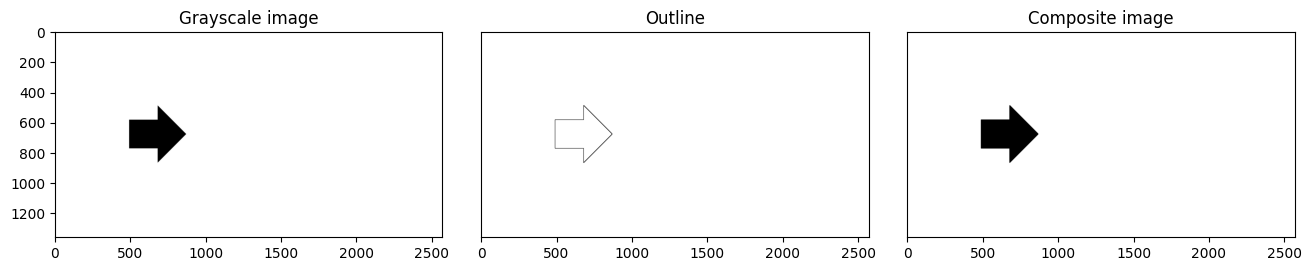

In [ ]:
# @title Option: outline { run: "auto", vertical-output: true }
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
kernel_size = 3  # @param {type:"integer"}
threshold1 = 312  # @param {type:"slider", min:0, max:500, step:1}
threshold2 = 8  # @param {type:"slider", min:0, max:500, step:1}

# Current Working Directory
CWD = os.getcwd()

# File paths
file_path_threshold = f"{CWD}/tmp/threshold.png"
file_path_outline = f"{CWD}/tmp/outline.png"
file_path_com = f"{CWD}/tmp/com.png"

# Read the resized image
IMG = cv2.imread(file_path_threshold, cv2.IMREAD_GRAYSCALE)

# Edge detection
edges_inverse = cv2.Canny(IMG, threshold1, threshold2)

# Dilate edges to make them thicker
num_iterations = 1
kernel = np.ones((kernel_size, kernel_size), np.uint8)
edges_dilated = cv2.dilate(edges_inverse, kernel, iterations=num_iterations)

# Invert the edges and save as outline image
edges = 255.0 - edges_dilated
cv2.imwrite(file_path_outline, edges)

# Normalize (0~1) edges: 0 -> black, 1 -> white
com = edges / 255.0
# Multiply the grayscale image (IMG) by the normalized edges
com = IMG * com
cv2.imwrite(file_path_com, com)

# Display images side by side using subplot
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Display the grayscale image
axs[0].imshow(cv2.cvtColor(cv2.imread(file_path_threshold), cv2.COLOR_BGR2RGB))
axs[0].set_title('Grayscale image')
axs[0].axis('on')

# Display the outline image
axs[1].imshow(cv2.cvtColor(cv2.imread(file_path_outline), cv2.COLOR_BGR2RGB))
axs[1].set_yticks([])
axs[1].set_title('Outline')
axs[1].axis('on')

# Display the composite image
axs[2].imshow(cv2.cvtColor(cv2.imread(file_path_com), cv2.COLOR_BGR2RGB))
axs[2].set_yticks([])
axs[2].set_title('Composite image')
axs[2].axis('on')

plt.subplots_adjust(wspace=0.1)
plt.show()


### 2-3-3 Projection Area

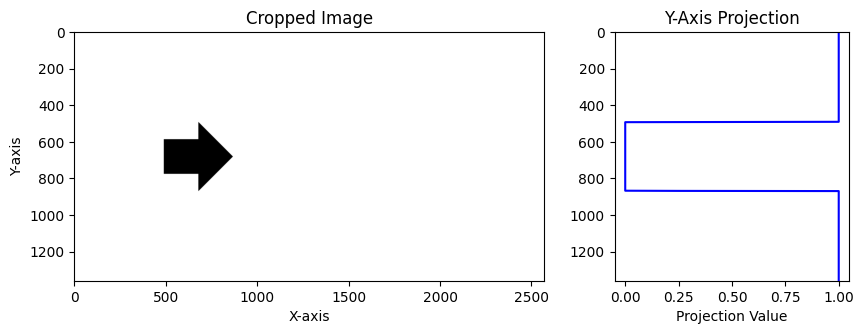

Y-Axis Projection Area to Range Ratio: 0.277
Successfull writing of info in ratio_of_objects.txt


In [ ]:
# @title Calculate ratio of the object { run: "auto", vertical-output: true }

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def compute_y_axis_projection_ratio(image_path):
    # Load the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Normalize the image to the range 0-1
    normalized_image = image / 255.0

    # Sum pixel values along the x-axis to compute the y-axis projection
    y_projection = np.prod(normalized_image, axis=1)

    # Calculate the y-range (total number of rows) and projected y-area
    y_range = normalized_image.shape[0]
    projected_area = np.sum(1-y_projection)

    # Compute the ratio of projected area to y-range
    ratio = projected_area / y_range

    # Plot results for visualization
    fig = plt.figure(figsize=(10, 6))  # 全体のサイズ
    gs = GridSpec(1, 2, width_ratios=[2, 1], wspace=0.2)  # 比率を調整して余白を小さく

    # Set y-axis limits for the original image
    ax0 = fig.add_subplot(gs[0])
    ax0.imshow(image, cmap="gray")
    ax0.set_title("Cropped Image")
    ax0.set_xlabel("X-axis")
    ax0.set_ylabel("Y-axis")
    ax0.axis("on")
    ax0.set_ylim(ax0.get_ylim()[::-1])  # y軸を反転して画像と一致

    # Y-axis projection histogram
    ax1 = fig.add_subplot(gs[1], sharey=ax0)  # y軸を共有して高さを一致
    ax1.plot(y_projection, range(len(y_projection)), color="blue")
    ax1.set_title("Y-Axis Projection")
    ax1.set_xlabel("Projection Value")
    ax1.set_ylabel("")  # 重複するyラベルを非表示
    ax1.invert_yaxis()  # y軸方向を一致

    bbox0 = ax0.get_position()
    bbox1 = ax1.get_position()
    ax1.set_position([bbox1.x0, bbox0.y0, bbox1.width, bbox0.height])

    plt.show()

    return ratio


# Example usage
image_path =  f"{CWD}/tmp/threshold.png"  # Provide the path to your grayscale image
ratio = compute_y_axis_projection_ratio(image_path)
print(f"Y-Axis Projection Area to Range Ratio: {ratio:.3f}")

# output variables
with open("config/ratio_of_objects.txt", "w") as file:
    file.write(f"{ratio}\n")
print("Successfull writing of info in ratio_of_objects.txt")


##2-4. Perform resizing and calculate fluid occupancy

1. **Resize**: Adjust the dimensions of the image using appropriate resizing techniques.

2. **Fluid Occupancy**: Determine the fluid occupancy rate by analyzing the resized image. This involves assessing the portion of the image occupied by the fluid, providing valuable insights into the fluid dynamics within the simulated environment.

###2-4-1. Resize
Resizing is done by the function `resize` of the OpenCV module. This function can scale an image by giving a scale factor. For example, a scale factor of 0.5 on a 100x100 image results in a 50x50 image.

Therefore, in order to convert an image to an arbitrary resolution, it is sufficient to know this scale factor. Let $\rm{(W, H)}$ denote the number of pixels in the original image and $\rm{(W', H')}$ the number of pixels in the converted image. Resolution is the total number of pixels, so if the original resolution is $\rm{R}$, the following equation holds.

$$ \rm{R} = WH$$

Here, the number of pixels in the height and width of the converted image $\rm{(W', H')}$ is defined using the scale factor $s( > 0)$ and $\rm{(W, H)}$ as follows.

$$ \rm{(W', H')} = (\textit{s}\rm{W}, \textit{s}\rm{H})$$

This allows the transformed resolution $\rm{R'}$ to be expressed as follows.

$$ \rm{R'} = W'H' = s^2\rm{WH} $$

Solving this for $s$, we obtain.

$$ s = \sqrt{\frac{R'}{WH}} $$

Therefore, given an arbitrary resolution, the coefficient $s$ can be obtained and resizing can be performed. Run the code block below and set the resolution by changing the slider bar of `resolution`. The last value you set will be the resolution used in the following program. The images are stored in the `tmp` folder.

###2-4-2. Fluid Occupancy


Defenition of porosity distribution:

\begin{equation}
\displaystyle \varepsilon = \frac{1}{2} \tanh(x) + \frac{1}{2},\   x = \frac{\xi}{\Delta}
\end{equation}

where $\xi$ is the signed distance function.

Complete


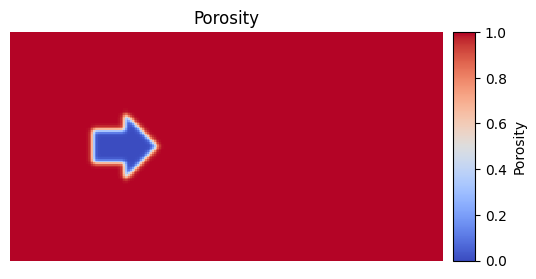

---------------- Processing Results ----------------
Setting resolution  =  34560 (135, 256)
Porosity resolution =  34560 (135, 256)
Delta (epsilon function):  1.5
Shade factor  :  1
Kernel size   :  5
Boundary area =  88.82
-----------------------------------------------------


In [ ]:
# @title Porosity Generation { vertical-output: true }

import seaborn as sns
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

x_resolution = 256  # @param {type: "integer"}
outline = True  # @param {type:"boolean"}
thickness = 1.5

CWD = os.getcwd()

# Define epsilon function
def epsilon(r, delta):
    return 0.5 * np.tanh(r / delta) + 0.5

# Define kernel function
def kernel_function(k, delta):
    r_values = np.linspace(-k, k, int(2*k+1))
    eps_values = epsilon(r_values, delta)
    kernel = 2 * eps_values * (1 - eps_values)
    kernel /= np.sum(kernel)  # Normalize
    return kernel

# Custom function to apply scale and kernel to generate porosity
def CustomScaledKernelPorosity(img, thickness, x_resolution):
    # Step 1: Rescale image
    h, w = img.shape[:2]
    scale_factor = x_resolution / max(h, w)
    scaled_img = cv2.resize(img, (int(w * scale_factor), int(h * scale_factor)), cv2.INTER_LINEAR)

    # Step 2: Generate kernel
    k = int(thickness) * 4 + (int(thickness) * 4 + 1) % 2  # Kernel size (ensure it's odd)
    kernel = kernel_function(k, thickness)
    kernel = np.outer(kernel, kernel)  # Create 2D kernel

    # Step 3: Apply kernel to scaled image
    img_blur = cv2.filter2D(scaled_img, -1, kernel)
    img_blur_norm = img_blur / 255.0

    return img_blur_norm, k

# File paths
if outline:
    file_name_input = f"{CWD}/tmp/com.png"
else:
    file_name_input = f"{CWD}/tmp/threshold.png"

file_name_output = f"{CWD}/tmp/porosity_image.png"

# Read the input image
input_image = cv2.imread(file_name_input, cv2.IMREAD_UNCHANGED)

# Define delta (adjustable parameter for epsilon function)
porosity, kernel_size = CustomScaledKernelPorosity(input_image, thickness, x_resolution)

# Divergence control of porosity distributions
h_resized, w_resized = porosity.shape[:2]

S = np.sum(porosity - porosity**2)

shade_factor = 1

# Initialization
data_write = np.empty((int(h_resized+1), int(w_resized)), dtype=object)
data_display = porosity

# Write porosity distribution
with open('data/porosity.csv', "w") as file:

    # Write header
    file.write(f"{int(w_resized)},{int(h_resized)},1, porosity\n")

    # Write data
    for j in range(1, h_resized+1):
        for i in range(1, w_resized+1):
            file.write(f"{int(i)}, {int(j)}, 1, {(porosity[h_resized - (j), (i -1)]):.5f}\n")

with open('logs/process.txt', 'w', encoding='utf-8') as f:
    print('---------------- Processing Results ----------------', file=f)
    print('Setting resolution  = ', porosity.shape[0]*porosity.shape[1], porosity.shape, file=f)
    print('Porosity resolution = ', (data_write.shape[0]-1)*data_write.shape[1], data_write[1:,:].shape, file=f)
    print('Delta (epsilon function): ', thickness, file=f)
    print('Shade factor  : ', shade_factor, file=f)
    print('Kernel size   : ', kernel_size, file=f)
    print('Boundary area = ', format(S, ".4"), file=f)
    print('-----------------------------------------------------', file=f)

print('Complete')

# Display images side by side using subplot
fig, ax = plt.subplots(figsize=(6, 6))

# Visualize porosity distribution using heatmap
sns.heatmap(
    porosity,
    cmap="coolwarm",
    xticklabels=False,
    yticklabels=False,
    square=True,
    ax=ax,
    cbar=False,
    # cbar_kws={"orientation": "vertical", "shrink": 0.8, "pad": 0.1}
)
ax.set_title("Porosity")

# Create a divider for the axes to adjust colorbar size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust size and padding as needed

norm = Normalize(vmin=porosity.min(), vmax=porosity.max())  # Normalize to A's range

# Create a ScalarMappable object
mappable = ScalarMappable(norm=norm, cmap="coolwarm")

# Add colorbar with the mappable object and set the label
fig.colorbar(mappable, cax=cax, label='Porosity')

# Save and show the plot
plt.savefig(file_name_output)
plt.show()

# Display the content of the process.txt file
%cat logs/process.txt

# 3. Simulation

Program for laminar flow calculations of the MAC algorithm using the Immersed boundary method.


### 3-1. Program

The program code is written using FORTRAN. The `data/porosity.csv` generated by the above code is read in and the flow field is calculated. The calculation results are output as a file in vtk format.

 Running Simulation Program will generate a file `main.f90` in the `src` folder. running Compile will compile `src/main.f90` and save it in `bin`. folder and an executable file named `run` is generated in the `bin` folder. In a terminal, type `. /run` in the terminal to run the program.

In [ ]:
#@title main.f90

%%writefile src/main.f90

program main
    !$ use omp_lib
     implicit none
     integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
     real:: dx, dy, dt
     real:: xnue, xlamda, density, width, height, time, inlet_velocity, outlet_pressure, AoA, thickness
     real,dimension(0:md,0:nd):: u, v, p, u_old, v_old, p_old
     real,dimension(0:md,0:nd):: porosity
     real,dimension(0:md):: xp
     real,dimension(0:nd):: yp

    ! ----------------
    ! local variables
     real:: residual_p, residual_u, residual_v
     real,parameter:: error_max=1.0e5
     integer:: m, n, istep, istep_max, iset, istep_out
     integer:: i, j
     character(len=50) :: output_folder
     character(len=50) :: csv_file
    ! ----------------
    ! read input data by using namelist
    ! by Nobuto Nakamichi 4/7/2023
    namelist /file_control/istep_out
    namelist /grid_control/istep_max
    namelist /directory_control/output_folder, csv_file
    open(11,file="config/controlDict.txt",status="old",action="read")
    read(11,nml=file_control)
    read(11,nml=grid_control)
    read(11,nml=directory_control)
    close(11)
    ! ----------------
    ! make output directory
    call system('mkdir -p '//trim(output_folder))
    ! -----------------

    ! ----------------
    ! calculation start  (if iest=!0)
    ! ----------------
    ! set up condistions
    m=0         ! setup switch for grid conditions
    density=0.  ! setup switch for physical conditions

    call  physical_conditions (xnue, xlamda, density, width, height, time &
                           , inlet_velocity, outlet_pressure, AoA, m, n)
    call  grid_conditions (xp, yp, dx, dy, dt, xnue, xlamda, density, width, height,&
                 thickness, time, inlet_velocity, AoA, porosity, m, n, istep_max, iset)

    istep = 0
    time = istep * dt

    ! ----------------

    write(*,*) 'istep_max= ', istep_max,'   istep_out= ', istep_out

    call  initial_conditions (p, u, v, xp, yp, width, height &
                           , inlet_velocity, outlet_pressure, AoA, m, n)
    call  boundary (p, u, v, xp, yp, width, height            &
                           , inlet_velocity, outlet_pressure, AoA, porosity, m, n)

    call output_solution_post (p, u, v, xp, yp, porosity, m, n, istep)
    ! ----------------
    ! MAC algorithm start

    do istep = 1, istep_max

      time = istep* dt
      residual_p = 0.0
      residual_u = 0.0
      residual_v = 0.0
      do i = 0, m+1
        do j = 0, n+1
          residual_p = max(residual_p, porosity(i,j) * abs(p(i,j) - p_old(i,j)))
          residual_u = max(residual_u, abs(u(i,j) - u_old(i,j)))
          residual_v = max(residual_v, abs(v(i,j) - v_old(i,j)))
          u_old(i,j) = u(i,j)
          v_old(i,j) = v(i,j)
          p_old(i,j) = p(i,j)
        end do
      end do
      write(*,*)'--- time_steps= ',istep, ' --  time = ',time
      write(*,*)'residual= p (fluid):', residual_p, 'u:', residual_u, 'v:', residual_v
      if (residual_p > error_max) then
        write(*,*)'Error value diverges. Terminate the process.'
        call exit(0)
      end if
      call  solve_p (p, u, v, u_old, v_old, porosity, xnue, xlamda, density, height, thickness, yp, dx, dy, dt, m, n)

      call  solve_u (p, u, v, u_old, v_old, porosity, xnue, xlamda, density, dx, dy, dt, m, n)

      call  solve_v (p, u, v, u_old, v_old, porosity, xnue, xlamda, density, dx, dy, dt, m, n)

      call  boundary(p, u, v, xp, yp, width, height    &
                          , inlet_velocity, outlet_pressure, AoA, porosity, m, n)

      if (mod(istep,istep_out)==0) then
        call output_solution_post (p, u, v, xp, yp, porosity, m, n, istep)
      end if

    end do
    ! MAC algorithm end
    ! ----------------

    ! print conditions (recall)
    call  physical_conditions (xnue, xlamda, density, width, height, time &
                           , inlet_velocity, outlet_pressure, AoA, m, n)
    call  grid_conditions (xp, yp, dx, dy, dt, xnue, xlamda, density, width, height, thickness, time &
    , inlet_velocity, AoA, porosity, m, n, istep_max, iset)

    ! print solutions
    call  output_paraview (p, u, v, porosity, xp, yp, m, n)
    call  output_solution (p, u, v, xp, yp, porosity, m, n)
    write(*,*) 'program finished'

    end program main
    !******************

    !  solve variables

    !******************
    subroutine  solve_p (p, u, v, u_old, v_old, porosity, xnue, xlamda, density, height,thickness, yp, dx, dy, dt, m, n)
     implicit none
     integer,parameter:: md = 4500, nd = 4500     ! md, nd > grid size (m,n)
     real,intent(in):: dx, dy, dt
     real,intent(in):: xnue, xlamda, density, height, thickness
     real,intent(inout),dimension(0:md,0:nd):: u, v, p, u_old, v_old
     real,intent(in),dimension(0:md,0:nd):: porosity
     real,intent(in),dimension(0:nd):: yp
     integer,intent(in):: m, n

    !-----------------
    ! local variables
     real, parameter:: small = 1.e-6, big = 1.e6, zero = 0.
     real, parameter::alpha = 32.0
     real,dimension(0:md,0:nd):: ap, ae, aw, an, as, bb, div
     integer:: i, j
     real:: fc

    !-----------------
    !  divergence term  div(u)
    !-----------------
    ! ----------------
    ! read input data by using namelist
    ! by Nobuto Nakamichi 27/7/2023
    logical::nonslip
    namelist /calculation_method/nonslip
    open(11,file="config/controlDict.txt",status="old",action="read")
    read(11,nml=calculation_method)
    close(11)
    ! ----------------
    do i = 1, m
        do j = 1, n
            div(i,j)= (u_old(i+1,j)-u_old(i-1,j))/dx*.5 &
                    + (v_old(i,j+1)-v_old(i,j-1))/dx*.5
        end do
    end do

    do j = 1, n
        div(0,j)  = 0.  ! inlet
        div(m+1,j)= 0.  ! outlet
    end do

    do i = 1, m
        div(i,0)  = div(i,n)  ! periodic condition
        div(i,n+1)= div(i,1)
    end do

    ! ----------------
    fc=0.

    do i = 1, m
    do j = 1, n
    ! ----------------
    !   velocity u
    ! ----------------
    ! convection_x  (1st upwind scheme)
    u(i,j)=u_old(i,j)-dt*(                  &
           fc*( max(u_old(i,j),0.)*(u_old(i,j)-u_old(i-1,j))/dx	  &      ! u>0 1st upwind scheme
               +min(u_old(i,j),0.)*(u_old(i+1,j)-u_old(i,j))/dx ) &      ! u<0 1st upwind scheme
     +(1.-fc)* u_old(i,j)*(u_old(i+1,j)-u_old(i-1,j))/dx/2.       )    ! 2nd central scheme

    ! convection_y
    u(i,j)=u(i,j)-dt*(						&
           fc*(max(v_old(i,j),0.)*(u_old(i,j)-u_old(i,j-1))/dy	&   ! v>0 1st upwind scheme
              +min(v_old(i,j),0.)*(u_old(i,j+1)-u_old(i,j))/dy) &   ! v<0 1st upwind scheme
     +(1.-fc)* v_old(i,j)*(u_old(i,j+1)-u_old(i,j-1))/dy/2.     ) ! 2nd central scheme

    ! diffusion_x
    u(i,j)=u(i,j) +dt*xnue*(u_old(i+1,j)-2.*u_old(i,j)+u_old(i-1,j))/dx/dx
    !      +dt*xnue/(small+porosity(i,j))*(u_old(i+1,j)-u_old(i-1,j))*(porosity(i+1,j)-porosity(i-1,j))/dx/dx*0.25 ! non-conseved term
    ! diffusion_y
    u(i,j)=u(i,j) +dt*xnue*(u_old(i,j+1)-2.*u_old(i,j)+u_old(i,j-1))/dy/dy
    !      +dt*xnue/(small+porosity(i,j))*(u_old(i,j+1)-u_old(i,j-1))*(porosity(i,j+1)-porosity(i,j-1))/dy/dy*0.25 ! non-conseved term
    ! divergence term
    u(i,j)=u(i,j) +dt*(xnue + xlamda)*(div(i+1,j)-div(i-1,j))/dx*.5
    ! additional terms by porosity profile   ! canceled for non-slip condition
    u(i,j)=u(i,j)							&
          +dt*( ( (u_old(i+1,j)-u_old(i-1,j))/dx*.5+(u_old(i+1,j)-u_old(i-1,j))/dx*.5) &
                  *xnue*(porosity(i+1,j)-porosity(i-1,j))/dx*.5                        &
               +( (u_old(i,j+1)-u_old(i,j-1))/dy*.5+(v_old(i+1,j)-v_old(i-1,j))/dx*.5) &
                  *xnue*(porosity(i,j+1)-porosity(i,j-1))/dy*.5                        &
                + div(i,j)*(porosity(i+1,j)-porosity(i-1,j))/dx*0.5*xlamda             &
               )/porosity(i,j)
    ! force on wall
    if (nonslip) then
      u(i,j)=u(i,j)- dt*xnue*u_old(i,j)/(thickness*dx)**2 *alpha*porosity(i,j)*(1.-porosity(i,j))*(1.-porosity(i,j))
    end if
    ! ----------------
    !   velocity v
    ! ----------------
    ! convection_x  (1st upwind scheme)
    v(i,j)=v_old(i,j)-dt*(						&
          fc *(max(u_old(i,j),0.)*(v_old(i,j)-v_old(i-1,j))/dx	&  ! u>0 1st upwind scheme
              +min(u_old(i,j),0.)*(v_old(i+1,j)-v_old(i,j))/dx) &  ! u<0 1st upwind scheme
     +(1.-fc)* u_old(i,j)*(v_old(i+1,j)-v_old(i-1,j))/dx/2.     ) ! 2nd central scheme

    ! convection_y
    v(i,j)=v(i,j)-dt*(							&
          fc *(max(v_old(i,j),0.)*(v_old(i,j)-v_old(i,j-1))/dy	&  ! v>0
              +min(v_old(i,j),0.)*(v_old(i,j+1)-v_old(i,j))/dy) &  ! v<0
     +(1.-fc)* v_old(i,j)*(v_old(i,j+1)-v_old(i,j-1))/dy/2.   ) ! 2nd central scheme

    ! diffusion_x
    v(i,j)=v(i,j) +dt*xnue*(v_old(i+1,j)-2.*v_old(i,j)+v_old(i-1,j))/dx/dx
    !      +dt*xnue/(small+porosity(i,j))*(v_old(i+1,j)-v_old(i-1,j))*(porosity(i+1,j)-porosity(i-1,j))/dx/dx*0.25 ! non-conseved term
    ! diffusion_y
    v(i,j)=v(i,j) +dt*xnue*(v_old(i,j+1)-2.*v_old(i,j)+v_old(i,j-1))/dy/dy
    !      +dt*xnue/(small+porosity(i,j))*(v_old(i,j+1)-v_old(i,j-1))*(porosity(i,j+1)-porosity(i,j-1))/dy/dy*0.25 ! non-conseved term
    ! divergence term   ! L+(2/3)N = (1/3)N;(2/3) or 0(1/3)
    v(i,j)=v(i,j) +dt*(xnue + xlamda)*(div(i,j+1)-div(i,j-1))/dy*.5
    ! additional terms by porosity profile   ! canceled for non-slip condition    ! L+(2/3)N = (1/3)N;(-1/3) or 0:(-2/3)N
    v(i,j)=v(i,j)							&
          +dt*( ( (v_old(i+1,j)-v_old(i-1,j))/dx*.5+(u_old(i,j+1)-u_old(i,j-1))/dy*.5) &
                  *xnue*(porosity(i+1,j)-porosity(i-1,j))/dx*.5                        &
               +( (v_old(i,j+1)-v_old(i,j-1))/dy*.5+(v_old(i,j+1)-v_old(i,j-1))/dy*.5) &
                  *xnue*(porosity(i,j+1)-porosity(i,j-1))/dy*.5                        &
               + div(i,j)*(porosity(i,j+1)-porosity(i,j-1))/dy*0.5*xlamda       &
               )/porosity(i,j)
    ! force on wall
    if (nonslip) then
      v(i,j)=v(i,j)- dt*xnue*v_old(i,j)/(thickness*dx)**2*alpha*porosity(i,j)*(1.-porosity(i,j))*(1.-porosity(i,j))
    end if
    end do
    end do

    ! ----------------
    ! matrix solution  !  formulation of porous media

    do i = 1, m
    do j = 1, n
    ae(i,j)= dt*max(small,(porosity(i+1,j)+porosity(i,j))*0.5)/dx/dx
    aw(i,j)= dt*max(small,(porosity(i,j)+porosity(i-1,j))*0.5)/dx/dx
    an(i,j)= dt*max(small,(porosity(i,j+1)+porosity(i,j))*0.5)/dy/dy
    as(i,j)= dt*max(small,(porosity(i,j)+porosity(i,j-1))*0.5)/dy/dy
    ap(i,j)= -ae(i,j)-aw(i,j)-an(i,j)-as(i,j)

    bb(i,j)= ((porosity(i+1,j)*u(i,j)+porosity(i,j)*u(i+1,j))*0.5             &
             -(porosity(i-1,j)*u(i,j)+porosity(i,j)*u(i-1,j))*0.5)*density/dx &
            +((porosity(i,j+1)*v(i,j)+porosity(i,j)*v(i,j+1))*0.5             &
             -(porosity(i,j-1)*v(i,j)+porosity(i,j)*v(i,j-1))*0.5)*density/dy

    end do
    end do

    call boundrary_matrix (p, ap, ae, aw, an, as, bb, m, n, height, yp)

    call solve_matrix_vec_omp (p, ap, ae, aw, an, as, bb, m, n)
    ! ----------------
    ! ----------------
    return
    end subroutine solve_p
    !******************

    !******************
    ! OpenMP Parallelized
    ! Written only for CPU machine
    ! No efficiency ensured on GPU machine
    subroutine  solve_matrix_vec_omp (p, ap, ae, aw, an, as, bb, m, n)
      implicit none
      integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
      real,intent(inout),dimension(0:md,0:nd):: p
      real,intent(in),dimension(0:md,0:nd):: ap, ae, aw, an, as, bb
      integer,intent(in):: m, n

     ! local variables
     real:: relux_factor
     real,dimension(0:md, 0:nd)::p_old
     integer:: i, j, iter, iter_max, k

     !$omp parallel private(iter, i, j, k) &
     !$omp & shared(iter_max, relux_factor, m, n) &
     !$omp & shared(p_old, p, ap, ae, aw, an, as, bb) &
     !$omp & default(none)

     ! ----------------
     !   SOR algorithm
     ! ----------------
     !$omp single
     iter_max = min(100, max(m, n)) ! SOR max interation steps
     relux_factor = 1.7 ! SOR reluxation factor
     !$omp end single

     do iter = 1, iter_max

       ! default periodic condition in y-direction
       !$omp do
       do i = 1, m
         p(i, 0) = p(i, n)
         p(i, n+1) = p(i, 1)
       end do
       !$omp end do

       !$omp do
       do i = 0, m+1
         do j = 0, n+1
           p_old(i, j) = p(i, j)
         end do
       end do
       !$omp end do

       !-- EVEN SPACE process
       !$omp do
       do k = 2, m*n, 2    ! even space
         j = (k - 1) / m + 1
         i = k - (j - 1) * m

         !-- IF m is EVEN (Based on Column-Major Order; FORTRAN)
         if(mod(m,2)==0 .and. mod(j,2)==0) i = i - 1

         p(i, j) = ( bb(i, j)                                                &
                    - ae(i, j) * p_old(i+1, j) - aw(i, j) * p_old(i-1, j)    &
                    - an(i, j) * p_old(i, j+1) - as(i, j) * p_old(i, j-1) )  &
                   / ap(i, j) * relux_factor                                 &
                  + p_old(i, j) * (1. - relux_factor)
       end do
      !$omp end do

       ! default periodic condition in y-direction
       !$omp do
       do i = 1, m
         p(i, 0)  = p(i, n)
         p(i, n+1) = p(i, 1)
       end do
       !$omp end do

       !$omp do
       do i = 0, m+1
         do j = 0, n+1
           p_old(i, j) = p(i, j)
         end do
       end do
       !$omp end do

       !-- ODD SPACE process
      !$omp do
       do k = 1, m*n, 2    ! odd space
         j = (k - 1) / m + 1
         i = k - (j - 1) * m

         !-- IF m is EVEN (Based on Column-Major Order; FORTRAN)
         if(mod(m,2)==0 .and. mod(j,2)==0) i = i + 1

         p(i, j) = ( bb(i, j)                                                &
                    - ae(i, j) * p_old(i+1, j) - aw(i, j) * p_old(i-1, j)    &
                    - an(i, j) * p_old(i, j+1) - as(i, j) * p_old(i, j-1) )  &
                   / ap(i, j) * relux_factor                                 &
                  + p_old(i, j) * (1. - relux_factor)
       end do
      !$omp end do

     end do

     ! default periodic condition in y-direction
     !$omp do
     do i = 1, m
       p(i, 0)   = p(i, n)
       p(i, n+1) = p(i, 1)
     end do
     !$omp end do

     !$omp end parallel

     return
     end subroutine solve_matrix_vec_omp
    !******************

    !******************
    subroutine  boundrary_matrix (p, ap, ae, aw, an, as, bb, m, n, height, yp)
     implicit none
     integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
     real,intent(in):: height
     real,intent(in),dimension(0:md,0:nd):: p
     real,intent(inout),dimension(0:md,0:nd):: ap, ae, aw, an, as, bb
     real,intent(in),dimension(0:nd):: yp
     integer,intent(in):: m, n

    ! local variables
    integer:: i, j

    ! ----------------
    ! inlet (dp/x=0 at i=1)
    do j= 1, n
     ae(1,j) =ae(1,j)+aw(1,j)
     aw(1,j) =0.
    end do

    ! outlet (p=outlet_pressure at i=m)
    do j= 1, n
     bb(m,j) =bb(m,j)+ae(m,j)*p(m+1,j)
     ae(m,j) = 0.
     aw(m,j) = 0.
     an(m,j) = 0.
     as(m,j) = 0.
    end do
    ! ----------------

    return
    end subroutine  boundrary_matrix
    !******************

    !******************
    subroutine  solve_u (p, u, v, u_old, v_old, porosity, xnue, xlamda, density, dx, dy, dt, m, n)
     implicit none
     integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
     real,intent(in):: dx, dy, dt
     real,intent(in):: xnue, xlamda, density
     real,intent(inout),dimension(0:md,0:nd):: u, v, p, u_old, v_old
     real,intent(in),dimension(0:md,0:nd):: porosity
     integer,intent(in):: m, n

    ! local variables
    integer::	i, j

    ! ----------------
    do i = 1, m
    do j = 1, n
    ! convection_x  (1st upwind scheme)
    ! (already calculated in solve_p)

    ! convection_y
    ! (already calculated in solve_p)

    ! diffusion_x
    ! (already calculated in solve_p)

    ! diffusion_y
    ! (already calculated in solve_p)

    ! pressure
    u(i,j)=u(i,j) -dt/density*(p(i+1,j)-p(i-1,j))/dx*0.5

    end do
    end do

    ! ----------------
    return
    end subroutine solve_u
    !******************

    !******************
    subroutine  solve_v (p, u, v, u_old, v_old, porosity, xnue, xlamda, density, dx, dy, dt, m, n)
     implicit none
     integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
     real,intent(in):: dx, dy, dt
     real,intent(in):: xnue, xlamda, density
     real,intent(inout),dimension(0:md,0:nd):: u, v, p, u_old, v_old
     real,intent(in),dimension(0:md,0:nd):: porosity
     integer,intent(in):: m, n

    ! local variables
    integer:: i, j

    ! ----------------
    do i = 1, m
    do j = 1, n
    ! convection_x  (1st upwind scheme)
    ! (already calculated in solve_p)

    ! convection_y
    ! (already calculated in solve_p)

    ! diffusion_x
    ! (already calculated in solve_p)

    ! diffusion_y
    ! (already calculated in solve_p)

    ! pressure
    v(i,j)=v(i,j) -dt/density*(p(i,j+1)-p(i,j-1))/dy*.5

    end do
    end do
    ! ----------------
    return
    end subroutine solve_v
    !******************

    !  conditions

    !******************
    subroutine  boundary(p, u, v, xp, yp, width, height    &
                         , inlet_velocity, outlet_pressure, AoA, porosity, m, n)
     implicit none
     integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
     real,intent(in):: width, height, inlet_velocity, outlet_pressure, AoA
     real,intent(inout),dimension(0:md,0:nd):: u, v, p
     real,intent(in),dimension(0:md,0:nd):: porosity
     real,intent(in),dimension(0:md):: xp
     real,intent(in),dimension(0:nd):: yp
     integer,intent(in):: m, n

    ! local variables
     real, parameter:: small=1.e-6, big=1.e6, zero=0., pai=atan(1.)*4.
     integer:: i, j

    ! ----------------
    ! inlet (u=inlet_velocity, v=0., dp/dx=0 at i=1)
    do j= 1, n
     u(1,j) =inlet_velocity*cos(AoA/180.*pai)
     v(1,j) =inlet_velocity*sin(AoA/180.*pai)
     u(0,j) =u(1,j) ! dummy
     v(0,j) =v(1,j) ! dummy
     p(0,j) =p(2,j)
    end do

    ! outlet (du/dx=0., dv/dx=0., p=outlet_pressure at i=m)
    do j= 1, n
     u(m+1,j) =u(m-1,j)
     v(m+1,j) =v(m-1,j)
    ! p(m,j) =outlet_pressure
     p(m+1,j)=outlet_pressure   ! dummy
    end do

    ! default: periodic condition (y-direction at j=1 & n)
    do i= 0, m+1
     u(i,0)   = u(i,n)
     v(i,0)   = v(i,n)
     p(i,0)   = p(i,n)
     u(i,n+1) = u(i,1)
     v(i,n+1) = v(i,1)
     p(i,n+1) = p(i,1)
    end do

    return
    end subroutine boundary
    !*****************************

    !*****************************
    subroutine physical_conditions(xnue, xlamda, density, width, height, time &
                                  , inlet_velocity, outlet_pressure, AoA, m, n)
     implicit none
     integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
     real,intent(inout):: xnue, xlamda, density, width, height, time  &
                           ,inlet_velocity, outlet_pressure, AoA
     integer,intent(in):: m, n
    ! local variables
     real:: reynolds_no, wing_length
     integer:: i, j
     real::depth

    ! ----------------

    ! ----------------
    ! read input file
    ! by Nobuto Nakamichi 4/7/2023
    namelist /physical/xnue, xlamda, density, width, height, depth, time  &
                     ,inlet_velocity, outlet_pressure, AoA

    if (density == 0.)then

      open(11,file="config/controlDict.txt",status="old",action="read")
      read(11,nml=physical)
      close(11)

    end if

    ! ----------------

    !wing_length =1.    ! (m)
    !reynolds_no=wing_length*inlet_velocity/xnue

    write(*,*)
    write(*,*) 'xnue ='	, xnue
    write(*,*) 'xlamda ='	, xlamda
    write(*,*) 'density ='	, density
    write(*,*) 'width ='	, width
    write(*,*) 'height ='	, height
    write(*,*) 'time ='	, time
    write(*,*) 'inlet_velocity ='	, inlet_velocity
    write(*,*) 'outlet_pressure ='	, outlet_pressure
    write(*,*) 'Angle of inlet_velocity (AoA) ='	, AoA
    !write(*,*) 'reynolds_no='	, reynolds_no

    ! ----------------

    return
    end subroutine physical_conditions
    !******************

    !******************
    subroutine  grid_conditions (xp, yp, dx, dy, dt, xnue, xlamda, density, width, height, thickness, time &
                                , inlet_velocity, AoA, porosity, m, n, istep_max, iset)
    implicit none
    integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
    real,intent(inout)::	dx, dy, dt, AoA, thickness
    real,intent(in)::	xnue, xlamda, density, width, height, time, inlet_velocity
    real,intent(inout),dimension(0:md,0:nd):: porosity
    real,intent(inout),dimension(0:md):: xp
    real,intent(inout),dimension(0:nd):: yp
    integer,intent(inout):: m, n, istep_max, iset
    character(len = 50) :: csv_file
    character(len = 50) :: output_folder

    ! local variables
    !real,dimension(0:md,0:nd)::	distance
    integer:: x, y, z
    real:: val, threshold
    real:: cfl_no, pecret_no, diffusion_factor, reynolds_no
    real:: pai, distance, center_x, center_y, radius
    integer::	i, j
    real, parameter:: small=1.e-6, big=1.e6, zero=0.
    ! ---

    ! ----------------
    ! namelist
    ! by Nobuto Nakamichi 4/7/2023
    namelist /grid_control/istep_max
    namelist /porosity_control/thickness, threshold
    namelist /directory_control/csv_file, output_folder
    open(11,file="config/controlDict.txt",status="old",action="read")
    read(11,nml=grid_control)
    read(11,nml=porosity_control)
    read(11,nml=directory_control)
    close(11)
    !-----------------

    ! read pixel data
    open(52,file=csv_file, form='formatted')

    read(52,*) m,n

    do i=1,m*n
      read(52,*) x, y, z, val
      porosity(x,y) = max(val, threshold)
    end do
    close(52)

    ! thickness = 2.5
    dx = width / real(m-1)
    dy = height / real(n-1)
    dt = time / real(istep_max)

    radius = 0.25 * height

    cfl_no           = inlet_velocity * dt / dx
    pecret_no        = inlet_velocity * dx / xnue
    diffusion_factor = xnue * dt / dy / dy

    !----- check print out
    write(*,*)
    write(*,*) 'm, n =', m, n
    write(*,*) 'istep_max =', istep_max
    write(*,*) 'dx, dy =', dx, dy
    write(*,*) 'dt =', dt
    write(*,*) 'cfl_no =', cfl_no
    write(*,*) 'pecret_no =', pecret_no
    write(*,*) 'diffusion_factor =', diffusion_factor
    write(*,*) 'thickness =', thickness
    write(*,*) 'threshold =', threshold

    do i = 0, m+1
    xp(i) = dx * real(i-1) - width*0.5
    end do

    do j = 0, n+1
    yp(j) = dy * real(j-1) - height*0.5
    end do

    ! default: outlet condtion in x-direction
    do j = 1, n+1
    porosity(0,j) = porosity(1,j)
    porosity(m+1,j) = porosity(m,j)
    end do

    ! default: periodic condtion in y-direction
    do i = 0, m+1
    porosity(i,0)   = porosity(i,n)
    porosity(i,n+1) = porosity(i,1)
    end do

    ! ----------------
    return
    end subroutine  grid_conditions
    !******************

    !******************
    subroutine  initial_conditions (p, u, v, xp, yp, width, height  &
                                   , inlet_velocity, outlet_pressure, AoA, m, n)
     implicit none
     integer,parameter:: md=4500, nd=4500     ! md, nd > grid size (m,n)
     real,intent(in):: width, height, inlet_velocity, outlet_pressure, AoA
     real,intent(out),dimension(0:md,0:nd):: u, v, p
     real,intent(in),dimension(0:md):: xp
     real,intent(in),dimension(0:nd):: yp
     integer,intent(in):: m, n

    ! local variables
    integer:: i, j
    real, parameter :: pai=atan(1.)*4.

    ! ----------------
    do j = 1, n
    do i = 1, m
     u(i,j)=inlet_velocity*cos(AoA/180*pai)
     v(i,j)=inlet_velocity*sin(AoA/180*pai)
     p(i,j)=outlet_pressure
    end do
    end do
    ! ----------------

    return
    end subroutine initial_conditions
    !******************

    !******************
    subroutine  output_solution (p, u, v, xp, yp, porosity, m, n)
    implicit none
    integer,parameter::md=4500, nd=4500     ! md, nd > grid size (m,n)
    real,intent(in),dimension(0:md,0:nd)::u, v, p
    real,intent(in),dimension(0:md,0:nd)::porosity
    real,intent(in),dimension(0:md)::xp
    real,intent(in),dimension(0:nd)::yp
    integer,intent(in)::m, n

    ! local variables
    real, parameter::small=1.e-6, big=1.e6, zero=0.
    real, parameter::pmin=0.25, pmax=0.75
    integer::i, j
    real,dimension(0:md, 0:nd)::u_cnt, v_cnt, p_cnt
    real::thickness, threshold

    ! ----------------
    ! namelist
    ! by Nobuto Nakamichi 4/7/2023
    namelist /porosity_control/thickness, threshold
    open(11,file="config/controlDict.txt",status="old",action="read")
    read(11,nml=porosity_control)
    close(11)
    !-----------------

    open (61, file='output/solution_uvp.csv', status='replace')

    ! ----------------
    ! interpolation at p-center grid

    do i = 1, m
    do j = 1, n
    u_cnt(i,j)=u(i,j)*porosity(i,j)
    v_cnt(i,j)=v(i,j)*porosity(i,j)
    if (porosity(i,j) > threshold)then
      p_cnt(i,j)=p(i,j)
    else
      p_cnt(i,j)=zero
    end if
    end do
    end do
    !-----------------
    ! write(61,*) m, n

    write(61, '(A, ",", A, ",", A, ",", A, ",", A, ",", A, ",", A, ",", A, ",", A)') &
    trim(adjustl('xp')), trim(adjustl('yp')), trim(adjustl('velocity_u_bulk')), trim(adjustl('velocity_v_bulk')), &
    trim(adjustl('velocity_u_inst')), trim(adjustl('velocity_v_inst')), trim(adjustl('pressure_p_fluid')), &
    trim(adjustl('pressure_p_all')), trim(adjustl('porosity'))

    do i = 1, m
    do j = 1, n
    write(61, '(F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8)') &
    xp(i), yp(j), u_cnt(i,j), v_cnt(i,j), u(i,j), v(i,j), p_cnt(i,j), p(i,j), porosity(i,j)
    end do
    end do
    close (61)
    ! ----------------

    ! ----------------
    ! surface profile
    open (62, file='output/surface_profile.csv', status='replace')

    write(62, '(A, ",", A, ",", A, ",", A)') &
    trim(adjustl('xp')), trim(adjustl('yp')), trim(adjustl('pressure_p_fluid')), trim(adjustl('surface'))

    do j=1,n
    do i=1,m
    if( porosity(i,j) < pmax .and. porosity(i,j)>pmin )then
    write(62,'(F12.8, ",", F12.8, ",", F12.8, ",", F12.8)')&
    xp(i), yp(j), p_cnt(i,j), porosity(i,j)
    end if
    end do
    end do
    close (62)
    ! ----------------


    return
    end subroutine output_solution
    !******************

    !******************
    subroutine  output_paraview (p, u, v, porosity, xp, yp, m, n)
     implicit none
     integer,parameter::	md=4500, nd=4500     ! md, nd > grid size (m,n)
     real,intent(in),dimension(0:md)::	xp
     real,intent(in),dimension(0:nd)::	yp
     real,intent(in),dimension(0:md, 0:nd)::	u, v, p
     real,intent(in),dimension(0:md,0:nd)::	porosity
     integer,intent(in)::	m, n
     integer::	i, j

    ! local variables
     real,dimension(0:md,0:nd):: div

     character(len=50)::csv_file
     character(len=50)::output_folder

     namelist /directory_control/csv_file, output_folder
     open(11,file="config/controlDict.txt",status="old",action="read")
     read(11,nml=directory_control)
     close(11)

    open(50,file=trim(output_folder)//'/output_paraview.vtk',status="unknown",form="formatted",position="rewind")
    !open(*,file='solution.vtk',status="replace")
    ! ----------------

        write(50,"('# vtk DataFile Version 3.0')")
        write(50,"('2D flow')")
        write(50,"('ASCII ')")

        write(50,"('DATASET STRUCTURED_GRID')")
        write(50,"('DIMENSIONS ',3(1x,i4))") m, n, 1

        write(50,"('POINTS ',i9,' float')") m*n
        do j=1,n
        do i=1,m
          write(50,"(3(f16.4,1x))") xp(i), yp(j), 0.0d0
        enddo
        enddo

        write(50,"('POINT_DATA ',i9)") m*n

    !! velocity vector
        write(50,"('VECTORS velocity float')")
        do j=1,n
        do i=1,m
          write(50,"(3(f16.4,1x))") u(i,j), v(i,j), 0.0d0
        enddo
        enddo

    !! velocity vector
        write(50,"('VECTORS velocityInFluid float')")
        do j=1,n
        do i=1,m
          write(50,"(3(f16.4,1x))") u(i,j)*porosity(i,j), v(i,j)*porosity(i,j), 0.0d0
        enddo
        enddo

    !! pressure
        write(50,"('SCALARS pressure float')")
        write(50,"('LOOKUP_TABLE default')")
        do j=1,n
        do i=1,m
          write(50,"(3(f16.4,1x))") p(i,j)
        enddo
        enddo

    do i = 1, m
    do j = 1, n
     div(i,j)= (u(i+1,j)-u(i-1,j))/(xp(j+1)-xp(j-1))+(v(i,j+1)-v(i,j-1))/(yp(j+1)-yp(j-1))
    end do
    end do

    !! divergent velocity
        write(50,"('SCALARS VelocityDivergent float')")
        write(50,"('LOOKUP_TABLE default')")
        do j=1,n
        do i=1,m
          write(50,"(3(f16.4,1x))") div(i,j)
        enddo
        enddo

    !! porosity
        write(50,"('SCALARS porosity float')")
        write(50,"('LOOKUP_TABLE default')")
        do j=1,n
        do i=1,m
          write(50,"(3(f16.4,1x))") porosity(i,j)
        enddo
        enddo

    ! ----------------
    close(50)

    return
    end subroutine  output_paraview
    !******************

    !******************
    subroutine output_solution_post (p, u, v, xp, yp, porosity, m, n, istep)
    implicit none
    integer, parameter:: md=4500, nd=4500   ! md, nd > grid size (m,n)
    real, intent(in), dimension(0:md, 0:nd):: u, v, p
    real, intent(in), dimension(0:md, 0:nd):: porosity
    real, intent(in), dimension(0:md):: xp
    real, intent(in), dimension(0:nd):: yp
    integer, intent(in):: m, n, istep

    ! local variables
    real, parameter:: small=1.e-6, big=1.e6, zero=0.
    real, parameter:: pmin=0.25, pmax=0.75
    integer:: i, j
    real, dimension(0:md, 0:nd):: u_cnt, v_cnt, p_cnt
    real:: thickness, threshold
    character(len=100):: file_name
    integer:: ios

    ! ----------------
    ! namelist
    ! by Nobuto Nakamichi 4/7/2023
    namelist /porosity_control/thickness, threshold
    open(11, file="config/controlDict.txt", status="old", action="read")
    read(11, nml=porosity_control)
    close(11)
    !-----------------

    ! Generate the file name with zero-padded istep
    write(file_name, '("output/solution_uvp_", I6.6, ".csv")') istep
    open(61, file=file_name, status='replace')

    ! ----------------
    ! interpolation at p-center grid
    do i = 1, m
      do j = 1, n
        u_cnt(i,j) = u(i,j) * porosity(i,j)
        v_cnt(i,j) = v(i,j) * porosity(i,j)
        if (porosity(i,j) > threshold) then
          p_cnt(i,j) = p(i,j)
        else
          p_cnt(i,j) = zero
        end if
      end do
    end do
    !-----------------
    ! Write header to output file
    write(61, '(A, ",", A, ",", A, ",", A, ",", A, ",", A, ",", A, ",", A, ",", A)') &
      trim(adjustl('xp')), trim(adjustl('yp')), trim(adjustl('velocity_u_bulk')), trim(adjustl('velocity_v_bulk')), &
      trim(adjustl('velocity_u_inst')), trim(adjustl('velocity_v_inst')), trim(adjustl('pressure_p_fluid')), &
      trim(adjustl('pressure_p_all')), trim(adjustl('porosity'))

    do i = 1, m
      do j = 1, n
        write(61, '(F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8, ",", F12.8)') &
          xp(i), yp(j), u_cnt(i,j), v_cnt(i,j), u(i,j), v(i,j), p_cnt(i,j), p(i,j), porosity(i,j)
      end do
    end do
    close(61)
    ! ----------------

    ! ----------------
    ! surface profile
    ! Generate the surface profile file name with zero-padded istep
    write(file_name, '("output/surface_profile_", I6.6, ".csv")') istep
    open(62, file=file_name, status='replace')

    write(62, '(A, ",", A, ",", A, ",", A)') &
      trim(adjustl('xp')), trim(adjustl('yp')), trim(adjustl('pressure_p_fluid')), trim(adjustl('surface'))

    do j = 1, n
      do i = 1, m
        if (porosity(i,j) < pmax .and. porosity(i,j) > pmin) then
          write(62, '(F12.8, ",", F12.8, ",", F12.8, ",", F12.8)') &
            xp(i), yp(j), p_cnt(i,j), porosity(i,j)
        end if
      end do
    end do
    close(62)
    ! ----------------

  return
  end subroutine output_solution_post
  !******************

Overwriting src/main.f90


In [ ]:
#@title Compile

%%sh

SRC_DIR='src'
SRC='main.f90'

FC='gfortran'
BIN_DIR='bin'
EXE='run'

#[MEMO] IF "2055 Segmentation fault (core dumped)" APPEARS, ADD "-fno-automatic".
FC_FLAG='-O3 -fopenmp -fno-automatic -o'

rm -f $BIN_DIR/$EXE

# In UNIX systems, excutable will be 'a.out' in defaults.
echo $FC $FC_FLAG $BIN_DIR/$EXE $SRC_DIR/$SRC
$FC $FC_FLAG $BIN_DIR/$EXE $SRC_DIR/$SRC

gfortran -O3 -fopenmp -fno-automatic -o bin/run src/main.f90


f951: Warning: Flag ‘-fno-automatic’ overwrites ‘-frecursive’ implied by ‘-fopenmp’


### 3-2. Settings

A controlDict.txt file enables to change some values from it. We need not recompile the program when we change any variables because of using namelist.  
\begin{align}
&CFL = \frac{U\Delta t}{\Delta x} \le 1 &\\
&Re = \frac{Ul}{\nu} = \frac{\rho Ul}{\mu}\\
&Pe = \frac{U\Delta x}{\nu} \le 2\\
&D = \frac{\nu\Delta t}{\Delta x^2} \le \frac{1}{2}
\end{align}

Where,  
$U$ = Inlet velocity  
$l$ = Representative length in flow direction  
$\nu$ = Kinematic viscosity  
$\mu$ = Dynamic viscosity  
$\rho$ = Density of the fluid

Large Peclet numbers mean that the advection term is dominant, which can lead to unstable calculations. As the program uses central differences, the stability condition for the Peclet number is $Pe < 2$.

#### Variable Description
- re: Reynolds number
- dt: time increment
- timeval: Simulation time
- safety_factor: safety factor (3 or more is recommended)
- ratio_of_objects: Ratio of the representative length of objects to the entire region
- AoA: Angle of Acceptance
- slip: Wall condition (noslip or slip)
- Run: When ☑ is checked, the simulation will start at runtime.
- Log: When ☑ is checked, the log file will be writed into `logs/log.txt`

In [ ]:
# @title Run { vertical-output: true }
%%time
import math
import time
import os
import cv2
import csv

# File path
file_path = 'data/porosity.csv'

# Clear All
!rm output/* fig/*

# Open the file and create a CSV reader
with open(file_path, 'r') as csvfile:
    reader = csv.reader(csvfile)

    # Read the header (first row)
    header = next(reader)

    # Extract the first two values from the header as w and h
    w, h = map(float, header[:2])

    resolution = w*h

    # Display the extracted values
    print(f'Width (w): {w}, Height (h): {h}')


# ========= Settings ==========
re = 32  # @param {type:"integer"}
dt = 0.01 # param {type:"raw"}
timeval = 10 # param {type:"raw"}
xnue = 0.001 # [m2/s]
xlamda = 0.000 # [m2/s]
porosity_threshold = 1.0e-2

# Safty Factor
safety_factor = 3 # @param {type:"integer"}

# Ratio of the representative length of an object to its WIDTH.
with open("config/ratio_of_objects.txt", 'r') as file:
    ratio_of_objects = float(file.readline().strip())

print(ratio_of_objects)

# [degree]
AoA = 0 # @param {type:"raw"}

density = 1.0 # [kg/m3]
outlet_pressure = 0.0 # [Pa]

slip = "noslip" # @param ["noslip", "slip"]
if slip == "noslip":
  nonslip = ".true."
else:
  nonslip = ".false."

output_num = 0
Run = True # @param {type:"boolean"}
Log = False # @param {type:"boolean"}
# ==============================

# Calculate
dx = math.sqrt(2*xnue*dt*safety_factor)
l = dx*w
depth = 0.000000
u = re*xnue/(l*(h/w)*ratio_of_objects)

istep_max = math.ceil(timeval / dt)

cfl = u*dt/dx
pe = u*dx/xnue
d = xnue*dt/dx/dx

length = l
height = l*(h/w)

inlet_velocity = u
dy = dx

step_out = int(istep_max/(max(output_num,1)))
if step_out == istep_max:
  step_out += 1

print('--------------- Settings ---------------')

print('CFL number            = ', format(cfl, '.5g'))
print('Reynolds number       = ', format(re, '.5g'))
print('Peclet number         = ', format(pe, '.5g'))
print('Diffusion factor      = ', format(d, '.5g'))
print('dx                    = ', format(dx, '.3e'), 'm')
print('dt                    = ', format(dt, '.3e'), 's')
print('inlet velocity        = ', format(u, '.5g'), 'm/s')
print('length                = ', format(l, '.5g'), 'm')
print('height                = ', format(height, '.5g'), 'm')
print('steps                 = ', istep_max)

with open('config/controlDict.txt','w',newline='\n',encoding='utf-8') as f:
    print("&physical\n\
xnue            = %f\n\
xlamda          = %f\n\
density         = %f\n\
width           = %f\n\
height          = %f\n\
depth           = %f\n\
time            = %f\n\
inlet_velocity  = %f\n\
outlet_pressure = %f\n\
AoA             = %f"\
          %(xnue,xlamda,density,l,height,depth,timeval,u,outlet_pressure,AoA),file=f)
    print("/",file=f)
    print("&file_control\nistep_out       = %d"%(step_out),file=f)
    print("/",file=f)
    print("&grid_control\nistep_max       = %d"%(istep_max),file=f)
    print("/",file=f)
    print("&porosity_control\n\
thickness       = %f\n\
threshold       = %f"\
    %(thickness,porosity_threshold),file=f)
    print("/",file=f)
    print("&calculation_method\nnonslip         = %s"%(nonslip),file=f)
    print("/",file=f)
    print("&directory_control\noutput_folder   = 'output'\ncsv_file        = 'data/porosity.csv'", file=f)
    print("/",file=f)

print('----------------------------------------')

if Run:
  !export OMP_NUM_THREADS=2
  !rm output/output*
  if Log:
      !echo Running...writing logs to logs/log.txt in progress
      !./bin/run > logs/log.txt
      !head -n 26 logs/log.txt
      !echo ...
      !tail -n 27 logs/log.txt | head -n 7
      !tail -n 1 logs/log.txt
  else:
      !./bin/run


# 4. Visualization

For visualization, utilize the Python module pyvista. It reads the VTK file generated by the Fortran program earlier and produces a colored image based on the values.

## 4-1. Surface profile

The porosity value of 0.5 represents the interface between the solid and fluid phases. As the interface is smoothly distributed, coordinates where the porosity values range from 0.25 to 0.75 are output to the file `output/surface_profile.csv`. By reading and visualizing this file as a colored scatter plot, you can inspect the boundary region.

#### Variable Description
- **colors**: Select the color map for data.

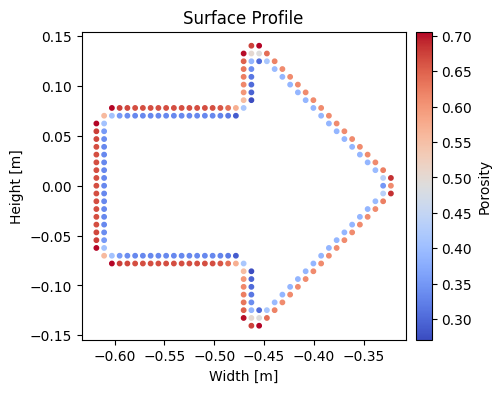

In [ ]:
# @title Surface profile { run: "auto", vertical-output: true, form-width: "40%" }

import pandas as pd
import matplotlib.pyplot as plt

# file path
file_path = 'output/surface_profile.csv'

# output file path
output_file_path = 'fig/surface.png'

# read data using pandas
df = pd.read_csv(file_path)

colors = 'coolwarm' # @param ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Create the scatter plot
mappable = ax.scatter(df['xp'], df['yp'], c=df['surface'], cmap=colors, s=10)

# Set titles and labels
ax.set_title('Surface Profile')
ax.set_xlabel('Width [m]')
ax.set_ylabel('Height [m]')
ax.set_aspect('equal')

# Create a divider for the axes to adjust colorbar size
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # Adjust size and padding as needed

# Add colorbar with the mappable object and set the label
fig.colorbar(mappable, cax=cax, label='Porosity')

# Save and display the plot
plt.savefig(output_file_path)
plt.show()

## 4-2. Display Output Data

The simulation results are output to a file named `output/solution_uvp.csv`. By reading this file, you can visualize the data as a colored scatter plot.

#### Variable Description
- **data**: [ velocity, pressure, porosity]
- **colors**: Select the color map for data.
- **streamlines**: When ☑ is checked, display streamlines
- **streamlines_color**: Select the color of the streamlines
- **density**: Specifiy the number of streamlines

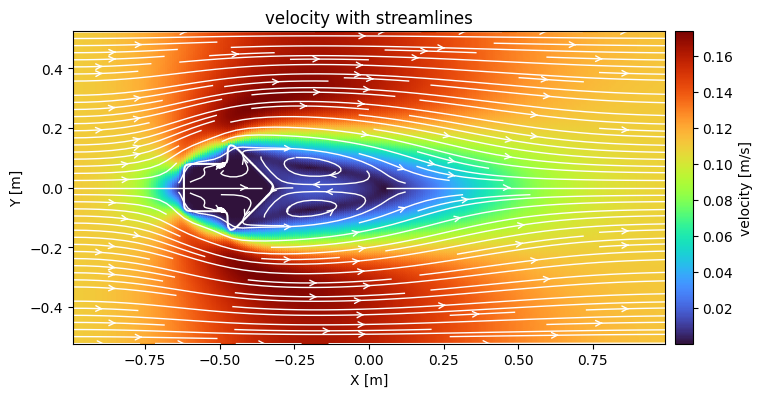

In [ ]:
# @title Display Results { run: "auto", vertical-output: true, form-width: "40%" }

import pandas as pd
import matplotlib.pyplot as plt


def plot_selected_variable(df, x_variable, y_variable, color_variable,
                           cmap, streamlines, density, streamlines_color,
                           contour, contour_color, contour_level,
                           title, file_path):

    fig, ax = plt.subplots(figsize=(8, 6))

    add_title = ''

    if streamlines:
      plot_streamlines(fig, ax, df, 'xp', 'yp', 'velocity_u_bulk', 'velocity_v_bulk', density, streamlines_color)
      add_title = ' with streamlines'

    scatter = ax.scatter(df[x_variable], df[y_variable], c=df[color_variable], cmap=cmap, s=10)

    if contour:
      plot_contour(fig, ax, df, x_variable, y_variable,
                   'porosity', contour_level, contour_color)

    ax.set_title(title)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_aspect('equal', 'box')

    unit = ''

    if title == 'velocity':
      unit = ' [m/s]'
    elif title == 'pressure':
      unit = ' [Pa]'

    # Adjust colorbar size
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(scatter, cax=cax)
    cbar.set_label(title + unit, fontsize=10)

    ax.set_ylim([np.min(df[y_variable]),np.max(df[y_variable])])
    ax.set_xlim([np.min(df[x_variable]),np.max(df[x_variable])])

    ax.set_title(title + add_title)
    ax.set_aspect('equal')
    plt.savefig(file_path)
    plt.show()

def plot_streamlines(fig, ax, df, x_variable, y_variable, u_variable, v_variable, density, color):

    # calculate absolute velocity and add table
    df['velocity_abs'] = np.sqrt(df[u_variable]**2 + df[v_variable]**2)

    # get range of grid
    x_range = np.linspace(df[x_variable].min(), df[x_variable].max(), len(np.unique(df[x_variable])))
    y_range = np.linspace(df[y_variable].min(), df[y_variable].max(), len(np.unique(df[y_variable])))

    # create grid
    X, Y = np.meshgrid(x_range, y_range)

    # get velocity vectors
    U = df[u_variable].values.reshape(len(x_range), len(y_range)).T
    V = df[v_variable].values.reshape(len(x_range), len(y_range)).T
    A = df['velocity_abs'].values.reshape(len(x_range), len(y_range)).T

    # render streamlines
    stream = ax.streamplot(X, Y, U, V, density=density, color=color, linewidth=1, arrowsize=1, arrowstyle='->')


def plot_contour(fig, ax, df, x_variable, y_variable, z_variable, level, color):
    # create grid
    x_range = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
    y_range = np.linspace(df[y_variable].min(), df[y_variable].max(), 100)
    X, Y = np.meshgrid(x_range, y_range)

    # interpolate z variable on grid
    Z = plt.tricontour(df[x_variable], df[y_variable], df[z_variable], levels=[level], colors=color)
    # ax.clabel(Z, fmt='%2.1f', colors=color, fontsize=12)

data = 'velocity' #@param ['velocity', 'pressure', 'porosity']
data_name = ['velocity_u_bulk','velocity_v_bulk','velocity_u_inst','velocity_v_inst','pressure_p_fluid','pressure_p_all','porosity']
colors = 'turbo' #@param ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral', 'gist_ncar']
streamlines = True # @param {type:"boolean"}
streamlines_density = 1.5 # @param {type:"slider", min:0.1, max:1.5, step:0.1}
streamlines_colors = 'white' #@param ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']
contour = True # @param {type:"boolean"}
contour_level = 0.7 # @param {type:"slider", min:0.1, max:0.9, step:0.1}
contour_colors = 'white' #@param ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'white']

# file path
file_path = 'output/solution_uvp.csv'

# read data file using pandas
df = pd.read_csv(file_path)

df['velocity_abs_bulk'] = np.sqrt(df['velocity_u_bulk']**2 + df['velocity_v_bulk']**2)
df['velocity_abs_inst'] = np.sqrt(df['velocity_u_inst']**2 + df['velocity_v_inst']**2)

if data == 'velocity':
  # output file path
  output_file_path = 'fig/velocity.png'
  variable_name = 'velocity_abs_bulk'
elif data == 'pressure':
  # output file path
  output_file_path = 'fig/pressure.png'
  variable_name = 'pressure_p_fluid'
elif data == 'porosity':
  # output file path
  output_file_path = 'fig/porosity.png'
  variable_name = 'porosity'

plot_selected_variable(df, 'xp', 'yp', variable_name, colors,
                       streamlines, streamlines_density, streamlines_colors,
                       contour, contour_colors, contour_level,
                       f'{data}', output_file_path)

In [ ]:
# @title Zip output file for download

%%capture

%mkdir -p download
%cp -r output download
%cp -r tmp download
%cp -r logs download
%cp -r fig download
!zip -r download download

#5. Reference

[1] Oshima, N., A novel approach for wall-boundary immersed flow simulation (proposal of modified Navier-Stokes equation), Journal of Fluid Science and Technology. Vol.18, No.4 (2023), https://doi.org/10.1299/jfst.2023jfst0034

[2] Oshima, N., A novel approach for wall-boundary immersed flow simulation (part 2: modeling of wall shear stress), Journal of Fluid Science and Technology. Vol.19, No.3 (2024), https://doi.org/10.1299/jfst.2024jfst0026

[3] Oshima, N., Program for flow simulation immersing wall boundary, Hokkaido university collection of scholarly and academic papers, http://hdl.handle.net/2115/89344

[4] Nakamichi, N., Cho, Y. and Oshima, N., Image-data-driven simulation of fluid dynamics (proposal and evaluation), Mechanical Engineering Journal, Advance online publication, https://doi.org/10.1299/mej.24-00196